# Tutorial: Boltzmann Machines

This shows how to train a Boltzmann machine, to sample from an observed probability distribution.

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 9, Tutorial (this is discussed in session 9)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook is distributed under the Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license:

https://creativecommons.org/licenses/by-sa/4.0/

This notebook shows how to:
- use a Boltzmann machine to sample from an observed high-dimensional probability distribution (e.g. produce images that look similar to observed training images)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']=90 # highres display

from IPython.display import clear_output
from time import sleep

In [8]:
def BoltzmannStep(v,b,w):
    """
    Perform a single step of the Markov chain,
    going from visible units v to hidden units h,
    according to biases b and weights w.
    
    z_j = b_j + sum_i v_i w_ij
    
    and P(h_j=1|v) = 1/(exp(-z_j)+1)
    
    Note: you can go from h to v, by inserting
    instead of v the h, instead of b the a, and
    instead of w the transpose of w
    """
    batchsize=np.shape(v)[0]
    hidden_dim=np.shape(w)[1]
    z=b+np.dot(v,w)
    P=1/(np.exp(-z)+1)
    # now, the usual trick to obtain 0 or 1 according
    # to a given probability distribution:
    # just produce uniform (in [0,1]) random numbers and
    # check whether they are below the cutoff given by P
    p=np.random.uniform(size=[batchsize,hidden_dim])
    return(np.array(p<=P,dtype='int'))
    
def BoltzmannSequence(v,a,b,w,drop_h_prime=False):
    """
    Perform one sequence of steps v -> h -> v' -> h'
    of a Boltzmann machine, with the given
    weights w and biases a and b!
    
    All the arrays have a shape [batchsize,num_neurons]
    (where num_neurons is num_visible for v and
    num_hidden for h)
    
    You can set drop_h_prime to True if you want to
    use this routine to generate arbitrarily long sequences
    by calling it repeatedly (then don't use h')
    Returns: v,h,v',h'
    """
    h=BoltzmannStep(v,b,w)
    v_prime=BoltzmannStep(h,a,np.transpose(w))
    if not drop_h_prime:
        h_prime=BoltzmannStep(v_prime,b,w)
    else:
        h_prime=np.zeros(np.shape(h))
    return(v,h,v_prime,h_prime)

def trainStep(v,a,b,w):
    """
    Given a set of randomly selected training samples
    v (of shape [batchsize,num_neurons_visible]), 
    and given biases a,b and weights w: update
    those biases and weights according to the
    contrastive-divergence update rules:
    
    delta w_ij = eta ( <v_i h_j> - <v'_i h'_j> )
    delta a_i  = eta ( <v_i> - <v'_i>)
    delta b_j  = eta ( <h_j> - <h'_j>)
    
    Returns delta_a, delta_b, delta_w, but without the eta factor!
    It is up to you to update a,b,w!
    """
    v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w)
    return( np.average(v,axis=0)-np.average(v_prime,axis=0) ,
            np.average(h,axis=0)-np.average(h_prime,axis=0) ,
            np.average(v[:,:,None]*h[:,None,:],axis=0)-
               np.average(v_prime[:,:,None]*h_prime[:,None,:],axis=0) )


In [9]:
def produce_samples_random_segment(batchsize,num_visible,max_distance=3):
    """
    Produce 'batchsize' samples, of length num_visible.
    Returns array v of shape [batchsize,num_visible]
    
    This here: produces randomly placed segments of
    size 2*max_distance.
    """
    random_pos=num_visible*np.random.uniform(size=batchsize)
    j=np.arange(0,num_visible)
    
    return( np.array( np.abs(j[None,:]-random_pos[:,None])<=max_distance, dtype='int' ) )

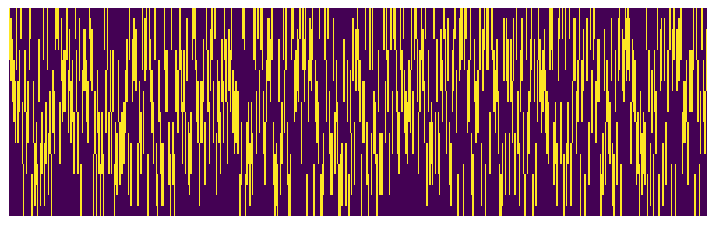

In [10]:
# Now: the training

num_visible=20
num_hidden=10
batchsize=50
eta=0.1
nsteps=500
skipsteps=10

a=np.random.randn(num_visible)
b=np.random.randn(num_hidden)
w=np.random.randn(num_visible,num_hidden)

test_samples=np.zeros([num_visible,nsteps])

for j in range(nsteps):
    v=produce_samples_random_segment(batchsize,num_visible)
    da,db,dw=trainStep(v,a,b,w)
    a+=eta*da
    b+=eta*db
    w+=eta*dw
    test_samples[:,j]=v[0,:]
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.figure(figsize=(10,3))
        plt.imshow(test_samples,origin='lower',aspect='auto',interpolation='none')
        plt.axis('off')
        plt.show()

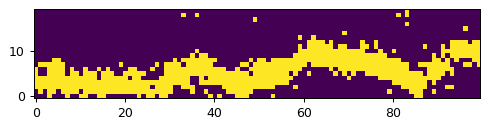

In [18]:
# Now: visualize the typical samples generated (from some starting point)
# run several times to continue this. It basically is a random walk
# through the space of all possible configurations, hopefully according
# to the probability distribution that has been trained!

nsteps=100
test_samples=np.zeros([num_visible,nsteps])

v_prime=np.zeros(num_visible)
h=np.zeros(num_hidden)
h_prime=np.zeros(num_hidden)

for j in range(nsteps):
    v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w,drop_h_prime=True) # step from v via h to v_prime!
    test_samples[:,j]=v[0,:]
    v=np.copy(v_prime) # use the new v as a starting point for next step!
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.imshow(test_samples,origin='lower',interpolation='none')
        plt.show()

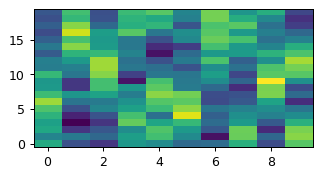

In [19]:
# Now show the weight matrix

plt.figure(figsize=(0.2*num_visible,0.2*num_hidden))
plt.imshow(w,origin='lower',aspect='auto')
plt.show()

# Tutorial: train on differently shaped samples (e.g. a bar with both random position and random width)

...or two bars, located always at the same distance!

In [43]:
def produce_samples_random_segment(batchsize,num_visible,max_distance=3):
    """
    Produce 'batchsize' samples, of length num_visible.
    Returns array v of shape [batchsize,num_visible]
    
    This here: produces randomly placed segments of
    size 2*max_distance.
    """
    random_pos = num_visible*np.random.uniform(size=batchsize)
    random_pos_2 = random_pos + 9
    j=np.arange(0,num_visible)
    a_1 = np.array( np.abs(j[None,:]-random_pos[:,None])<=max_distance, dtype='int' )
    a_2 = np.array( np.abs(j[None,:]-random_pos_2[:,None])<=max_distance, dtype='int' )
    return( a_1+a_2 )

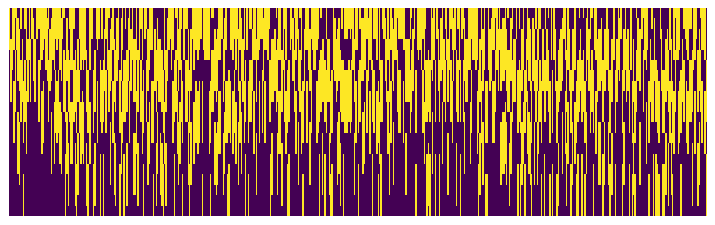

In [44]:
# Now: the training

num_visible=20
num_hidden=10
batchsize=50
eta=0.1
nsteps=500
skipsteps=10

a=np.random.randn(num_visible)
b=np.random.randn(num_hidden)
w=np.random.randn(num_visible,num_hidden)

test_samples=np.zeros([num_visible,nsteps])

for j in range(nsteps):
    v=produce_samples_random_segment(batchsize,num_visible)
    da,db,dw=trainStep(v,a,b,w)
    a+=eta*da
    b+=eta*db
    w+=eta*dw
    test_samples[:,j]=v[0,:]
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.figure(figsize=(10,3))
        plt.imshow(test_samples,origin='lower',aspect='auto',interpolation='none')
        plt.axis('off')
        plt.show()

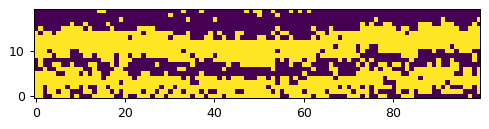

In [45]:
# Now: visualize the typical samples generated (from some starting point)
# run several times to continue this. It basically is a random walk
# through the space of all possible configurations, hopefully according
# to the probability distribution that has been trained!

nsteps=100
test_samples=np.zeros([num_visible,nsteps])

v_prime=np.zeros(num_visible)
h=np.zeros(num_hidden)
h_prime=np.zeros(num_hidden)

for j in range(nsteps):
    v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w,drop_h_prime=True) # step from v via h to v_prime!
    test_samples[:,j]=v[0,:]
    v=np.copy(v_prime) # use the new v as a starting point for next step!
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.imshow(test_samples,origin='lower',interpolation='none')
        plt.show()

# Homework: train on MNIST images!

Here the visible units must be a flattened version of the images, something like

v=np.reshape(image,[batchsize,widh*height])

...if image is of shape [batchsize,width,height], meaning an array holding the pixel values for all images in a batch!

...to plot the results, you would use 

np.reshape(v,[batchsize,width,height])

to get back to the image format!

In [47]:
# Import keras library. Also import some of the layers, so we do not need to
# write things like "layers.Dense", but can just write "Dense" instead
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GaussianDropout
import tensorflow.keras.optimizers as optimizers

# Import the numpy library for matrix manipulations etc.

#from numpy import *
from numpy import array, zeros, exp, random, dot, shape, transpose, reshape, meshgrid, linspace, sqrt, sum, argmax, where

# Set up the graphics by importing the matplotlib plotting library
import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=90 # highres display

# Set up a random number generator with a fixed seed, so that
# running this whole notebook repeatedly should always give
# the same result (useful for debugging)
rng = random.RandomState(23455)

import time

2023-06-16 11:05:35.625095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
"""
mnist_loader
~~~~~~~~~~~~

taken from Nielsen's online book:
http://neuralnetworksanddeeplearning.com/chap1.html


A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    
    global training_inputs, training_results
    global validation_inputs, validation_results
    global test_inputs, test_results
    global num_samples, numpixels, num_test_samples
    
    tr_d, va_d, te_d = load_data()
    
    num_samples=len(tr_d[0])
    training_inputs=zeros([num_samples,numpixels])
    training_results=zeros([num_samples,10])    
    for j in range(num_samples):
        training_inputs[j,:] = reshape(tr_d[0][j], (numpixels))
        training_results[j,:] = vectorized_result(tr_d[1][j])
#    validation_inputs = [reshape(x, (numpixels)) for x in va_d[0]]
#    validation_results = [vectorized_result(y) for y in va_d[1]]

    num_test_samples=len(te_d[0])
    test_inputs=zeros([num_test_samples,numpixels])
    test_results=zeros([num_test_samples,10])    
    for j in range(num_test_samples):
        test_inputs[j,:] = reshape(te_d[0][j], (numpixels))
        test_results[j,:] = vectorized_result(te_d[1][j])

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = zeros((10))
    e[j] = 1.0
    return e

In [54]:
numpixels=784
load_data_wrapper() # load all the MNIST images

In [55]:
shape(training_inputs)

(50000, 784)

In [74]:
psi=training_inputs-sum(training_inputs,axis=0)/num_samples

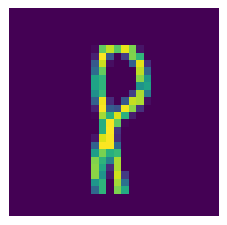

In [83]:
# Now: the training

num_visible=784
num_hidden=100
batchsize=50
eta=0.1
nsteps=500
skipsteps=10

a=np.random.randn(num_visible)
b=np.random.randn(num_hidden)
w=np.random.randn(num_visible,num_hidden)

test_samples=np.zeros([num_visible,nsteps])

for j in range(nsteps):
    v= training_inputs[j*batchsize:(j+1)*batchsize,:]
    da,db,dw=trainStep(v,a,b,w)
    a+=eta*da
    b+=eta*db
    w+=eta*dw
    test_samples[:,j]=v[0,:]
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.figure(figsize=(3,3))
        plt.imshow(np.reshape(test_samples[:,j],[28,28]),origin='upper',aspect='auto',interpolation='none')
        plt.axis('off')
        plt.show()

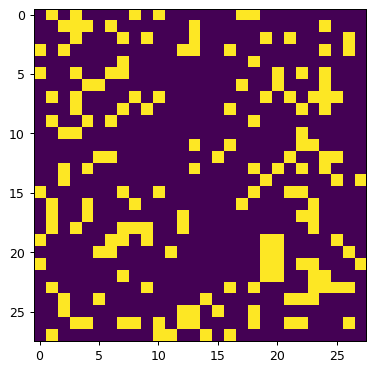

In [84]:
# Now: visualize the typical samples generated (from some starting point)
# run several times to continue this. It basically is a random walk
# through the space of all possible configurations, hopefully according
# to the probability distribution that has been trained!

nsteps=300
test_samples=np.zeros([num_visible,nsteps])

v_prime=np.zeros(num_visible)
h=np.zeros(num_hidden)
h_prime=np.zeros(num_hidden)

for j in range(nsteps):
    v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w,drop_h_prime=True) # step from v via h to v_prime!
    test_samples[:,j]=v[0,:]
    v=np.copy(v_prime) # use the new v as a starting point for next step!
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.imshow(np.reshape(test_samples[:,j],[28,28]),origin='upper',interpolation='none')
        plt.show()